# 📦 Install prerequisites

In [1]:
!pip install pytorch-tabnet xgboost scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00


# 📌 Importing libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 📥 load dataset

In [4]:
df = pd.read_csv("/content/Obfuscated-MalMem2022.csv")

# 🎯 Tagging

In [5]:
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

# 📊 Separating inputs and outputs

In [6]:
X = df.drop(columns=["Class", "Category"])
y = df["Class"].values

# ⚖️ Feature Normalization

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔀 Data sharing

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 💠 Conversion for TabNet

In [17]:
X_train_tab = X_train.astype(np.float32)
X_test_tab = X_test.astype(np.float32)
y_train_tab = y_train.astype(np.int64)
y_test_tab = y_test.astype(np.int64)

# 🧠 TabNet model training

In [18]:
clf_tabnet = TabNetClassifier(verbose=0)
clf_tabnet.fit(X_train_tab, y_train_tab,
               eval_set=[(X_test_tab, y_test_tab)],
               max_epochs=200,
               patience=20)


Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_auc = 0.99999


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# ✅ TabNet Prediction

In [19]:
y_pred_tabnet = clf_tabnet.predict(X_test_tab)
print("🧠 TabNet:\n", classification_report(y_test_tab, y_pred_tabnet))

🧠 TabNet:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5860
           1       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720



# 🔍 Importance of features in TabNet

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


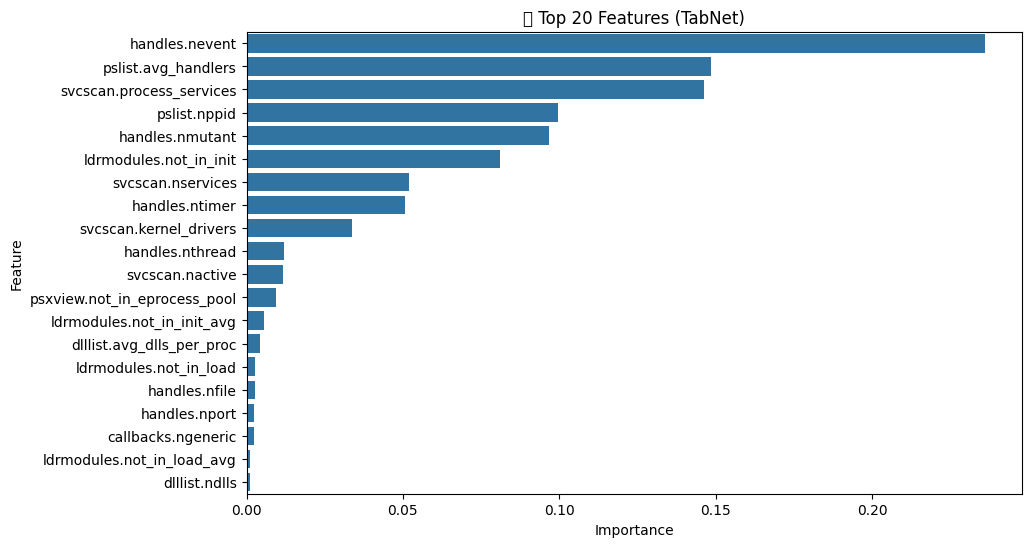

In [20]:
feat_importance = clf_tabnet.feature_importances_
features = X.columns
imp_df = pd.DataFrame({'Feature': features, 'Importance': feat_importance})
imp_df = imp_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df[:20], x="Importance", y="Feature")
plt.title("🔥 Top 20 Features (TabNet)")
plt.show()

# 🌲 Random Forest Model Training

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("🌳 Random Forest:\n", classification_report(y_test, y_pred_rf))

🌳 Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5860
           1       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720



# 🔁 XGBoost model training

In [22]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("🚀 XGBoost:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:10:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🚀 XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5860
           1       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720



# 📌 Display TabNet confusion matrix

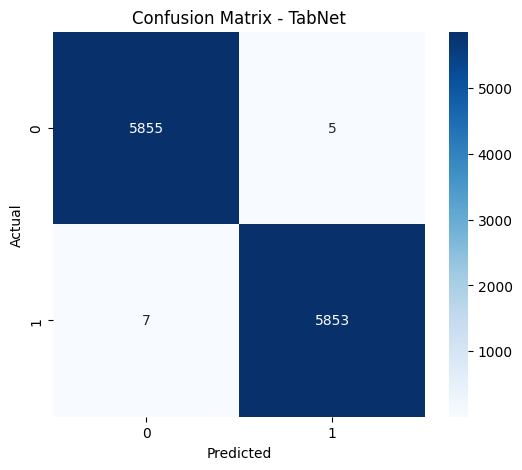

In [23]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_tab, y_pred_tabnet), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - TabNet")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 💾 Save the TabNet model for future use

In [24]:
model_save_path = "/content/tabnet_model.zip"
clf_tabnet.save_model(model_save_path)
print(f"✅ TabNet model saved at {model_save_path}")

Successfully saved model at /content/tabnet_model.zip.zip
✅ TabNet model saved at /content/tabnet_model.zip
